In [1]:
import math
import numpy as np
import pandas as pd
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Tree definition (reused from baseline)
def create_tree_polygon(x, y, angle_deg):
    """Create tree polygon at given position and angle."""
    # Tree vertices (relative to center at origin)
    trunk_w = 0.15
    trunk_h = 0.2
    base_w = 0.7
    mid_w = 0.4
    top_w = 0.25
    tip_y = 0.8
    tier_1_y = 0.5
    tier_2_y = 0.25
    base_y = 0.0
    trunk_bottom_y = -trunk_h
    
    vertices = [
        (0.0, tip_y),
        (top_w/2, tier_1_y),
        (top_w/4, tier_1_y),
        (mid_w/2, tier_2_y),
        (mid_w/4, tier_2_y),
        (base_w/2, base_y),
        (trunk_w/2, base_y),
        (trunk_w/2, trunk_bottom_y),
        (-trunk_w/2, trunk_bottom_y),
        (-trunk_w/2, base_y),
        (-base_w/2, base_y),
        (-mid_w/4, tier_2_y),
        (-mid_w/2, tier_2_y),
        (-top_w/4, tier_1_y),
        (-top_w/2, tier_1_y),
    ]
    
    # Create polygon
    poly = Polygon(vertices)
    
    # Rotate
    poly = affinity.rotate(poly, angle_deg, origin=(0, 0))
    
    # Translate
    poly = affinity.translate(poly, x, y)
    
    return poly

def validate_packing(trees):
    """
    Validate that no trees overlap.
    trees: list of shapely Polygons
    Returns: valid (bool), overlapping_indices (list of tuples)
    """
    valid = True
    overlaps = []
    n = len(trees)
    
    # Naive O(N^2) check - sufficient for N=200
    for i in range(n):
        for j in range(i + 1, n):
            if trees[i].intersects(trees[j]):
                # Check if it's just touching (intersection is line or point)
                intersection = trees[i].intersection(trees[j])
                if intersection.area > 1e-9: # Tolerance for floating point
                    valid = False
                    overlaps.append((i, j))
                    
    return valid, overlaps

def calculate_exact_score(trees, n):
    """
    Calculate score using the bounding box of the union of polygons.
    """
    if not trees:
        return 0
    
    # Union of all trees
    # unary_union is efficient
    combined = unary_union(trees)
    
    min_x, min_y, max_x, max_y = combined.bounds
    
    side = max(max_x - min_x, max_y - min_y)
    score = side**2 / n
    return score

print("Validation and scoring functions defined.")

Validation and scoring functions defined.


Best packing found:
           dx        dy         w         h      area
330  0.428571  0.479592  1.128571  1.120408  1.264461
357  0.442857  0.479592  1.142857  1.120408  1.280466
385  0.457143  0.479592  1.157143  1.120408  1.296472
356  0.442857  0.459184  1.142857  1.140816  1.303790
449  0.485714  0.500000  1.185714  1.100000  1.304286


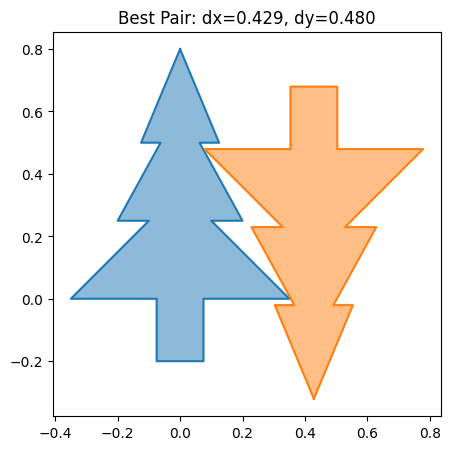

In [3]:
# Define plot_packing locally since it was in previous notebook
def plot_packing(trees, title="Packing"):
    fig, ax = plt.subplots(figsize=(5, 5))
    for tree in trees:
        x, y = tree.exterior.xy
        ax.plot(x, y)
        ax.fill(x, y, alpha=0.5)
    ax.set_aspect('equal')
    plt.title(title)
    plt.show()

# Experiment: Find optimal spacing for interlocked pair
def find_optimal_spacing():
    t1 = create_tree_polygon(0, 0, 0)
    
    # Grid search for best position for t2 (180 deg)
    # We expect t2 to be somewhere to the right and maybe vertically aligned or shifted
    
    # Try to place t2 at (dx, dy) with 180 rotation
    # We want to minimize max(bounds) - min(bounds) roughly, or just find valid positions
    
    valid_positions = []
    
    # Search range
    dx_range = np.linspace(0.1, 0.8, 50)
    dy_range = np.linspace(-0.5, 0.5, 50)
    
    for dx in dx_range:
        for dy in dy_range:
            t2 = create_tree_polygon(dx, dy, 180)
            
            # Check intersection with tolerance
            if not t1.intersects(t2):
                # Valid
                # Calculate combined width/height
                combined = unary_union([t1, t2])
                minx, miny, maxx, maxy = combined.bounds
                w = maxx - minx
                h = maxy - miny
                area = w * h # Proxy for efficiency
                valid_positions.append({'dx': dx, 'dy': dy, 'w': w, 'h': h, 'area': area})
                
    df = pd.DataFrame(valid_positions)
    return df

results = find_optimal_spacing()
if not results.empty:
    print("Best packing found:")
    print(results.sort_values('area').head())

    # Visualize the best one
    best = results.sort_values('area').iloc[0]
    t1 = create_tree_polygon(0, 0, 0)
    t2 = create_tree_polygon(best['dx'], best['dy'], 180)
    plot_packing([t1, t2], f"Best Pair: dx={best['dx']:.3f}, dy={best['dy']:.3f}")
else:
    print("No valid packing found in range")